[View in Colaboratory](https://colab.research.google.com/github/loloaquarius/Coursera_Capstone/blob/master/Capstone_Project_Toronto.ipynb)

<h1 align=center><font size = 5>Where are the most appropriate neighborhood in Toronto to locate your new KFC restaurant?</font></h1>

## Introduction

There are currently dozens of KFC restaurants located in Toronto among hundreds outlets from other giant fast food chains. But with the strong consumer awareness of American food and beverages and fast growing of Food consumption in the city. It is expected that the market is still expanding rapidly in coming years. However, it is not easy to find a suitable location for your new KFC restaurant here. The objective of this analytics, is to solve that problem based on neighborhoods and corresponding venues data in Toronto in addition other data.

## Table of Contents

<div class="alert alert-block alert-info" style="margin-top: 20px">

<font size = 2>
1. <a href="#item1">Download, Cleaning and Explore Dataset</a>    
2. <a href="#item2">Explore Neighborhoods</a>  
3. <a href="#item3">Build the predict model</a>  
4. <a href="#item4">Analyze and Result</a>    
5. <a href="#item5">References</a>    
</font>
</div>

**Install lxml and geopy libraries using for parsing html and get coordinates**

In [1]:
!pip install lxml
!pip install geopy

    100% |████████████████████████████████| 5.8MB 4.3MB/s 
    100% |████████████████████████████████| 92kB 4.3MB/s 
  Running setup.py bdist_wheel for geographiclib ... - done
  Stored in directory: /root/.cache/pip/wheels/99/45/d1/14954797e2a976083182c2e7da9b4e924509e59b6e5c661061
Successfully built geographiclib


**Import necessary libraries and modules into project:**

In [0]:
import requests # library to handle requests
from geopy.geocoders import Nominatim
import lxml # dependency library
import pandas as pd # library for data analsysis
from bs4 import BeautifulSoup # library for parsing HTML
import numpy as np # library to handle data in a vectorized manner

## 1. Download and explore data set <a id="item1"></a>

**Create a dataframe from demographics table of neighborhoods of Toronto on wikipedia**

In [3]:
toronto_df = pd.read_html('https://en.wikipedia.org/wiki/Demographics_of_Toronto_neighbourhoods',header=0,attrs={'class':'wikitable'})[0]
toronto_df.head()

,Name,FM,Census Tracts,Population,Land area (km2),Density (people/km2),% Change in Population since 2001,Average Income,Transit Commuting %,% Renters,Second most common language (after English) by name,Second most common language (after English) by percentage,Map
0,Toronto CMA Average,NaN,All,5113149,5903.63,866,9.0,40704,10.6,11.4,NaN,NaN,NaN
1,Agincourt,S,"0377.01, 0377.02, 0377.03, 0377.04, 0378.02, 0...",44577,12.45,3580,4.6,25750,11.1,5.9,Cantonese (19.3%),19.3% Cantonese,NaN
2,Alderwood,E,"0211.00, 0212.00",11656,4.94,2360,-4.0,35239,8.8,8.5,Polish (6.2%),06.2% Polish,NaN
3,Alexandra Park,OCoT,0039.00,4355,0.32,13609,0.0,19687,13.8,28.0,Cantonese (17.9%),17.9% Cantonese,NaN
4,Allenby,OCoT,0140.00,2513,0.58,4333,-1.0,245592,5.2,3.4,Russian (1.4%),01.4% Russian,NaN


**Just keep information which I think affect to locating new KFC restaurant such as Neighborhood Name, Area, Population Density and Average Income**

In [4]:
toronto_df = toronto_df[['Name','Land area (km2)','Density (people/km2)','Average Income']]
toronto_df.columns =['Neighborhood','Area','PoDensity','AvgIncome']
toronto_df.head()

,Neighborhood,Area,PoDensity,AvgIncome
0,Toronto CMA Average,5903.63,866,40704
1,Agincourt,12.45,3580,25750
2,Alderwood,4.94,2360,35239
3,Alexandra Park,0.32,13609,19687
4,Allenby,0.58,4333,245592


**Check out the shape of data**

In [5]:
toronto_df.shape

(175, 4)

**Features above are not enough to evaluate which neighborhood is most suitable for opening a new restaurant, I need to find more data. I use data from City of Toronto Information Portal**

In [6]:
!rm WB-Economics.xlsx
!rm WB-Safety.xlsx

rm: cannot remove 'WB-Economics.xlsx': No such file or directory
rm: cannot remove 'WB-Safety.xlsx': No such file or directory


In [7]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving WB-Economics.xlsx to WB-Economics.xlsx
Saving WB-Safety.xlsx to WB-Safety.xlsx
User uploaded file "WB-Economics.xlsx" with length 16956 bytes
User uploaded file "WB-Safety.xlsx" with length 21243 bytes


**Read excel files using pandas**

In [8]:
!pip install xlrd

    100% |████████████████████████████████| 112kB 4.3MB/s 


In [0]:
eco_df = pd.read_excel('WB-Economics.xlsx',header=0, skiprows=[0])
safety_df = pd.read_excel('WB-Safety.xlsx',header=0, skiprows=[0])

In [10]:
eco_df.head()

,Neighbourhood,Neighbourhood Id,Businesses,Child Care Spaces,Debt Risk Score,Home Prices,Local Employment,Social Assistance Recipients
0,West Humber-Clairville,1,2463,195,719,317508,58271,2912
1,Mount Olive-Silverstone-Jamestown,2,271,60,687,251119,3244,6561
2,Thistletown-Beaumond Heights,3,217,25,718,414216,1311,1276
3,Rexdale-Kipling,4,144,75,721,392271,1178,1323
4,Elms-Old Rexdale,5,67,60,692,233832,903,1683


In [11]:
safety_df.head()

,Neighbourhood,Neighbourhood Id,Arsons,Assaults,Break & Enters,Drug Arrests,Fire Medical Calls,Fire Vehicle Incidents,Fires & Fire Alarms,Hazardous Incidents,Murders,Robberies,Sexual Assaults,Thefts,Total Major Crime Incidents,Vehicle Thefts
0,West Humber-Clairville,1,4,390,175,62,1321,502,705,210,0,82,68,54,1119,288
1,Mount Olive-Silverstone-Jamestown,2,3,316,61,90,1016,59,361,176,1,78,75,7,690,62
2,Thistletown-Beaumond Heights,3,0,85,36,16,323,48,90,34,0,17,24,2,192,12
3,Rexdale-Kipling,4,0,59,32,15,305,34,94,55,1,16,20,3,164,18
4,Elms-Old Rexdale,5,1,77,25,14,321,71,107,43,0,23,5,19,185,22


**At this step, I discover somthing strange about open data of city of Toronto, many neighborhoods existing in Toronto but are not available in open data and vice versa!!! I do not know why. I try to loop through eco_df data frame to find out which Toronto Neighborhoods available there**

In [0]:
HomePrices = []
TotalCrimeCases = []

In [0]:
for neighborhood in toronto_df.Neighborhood:
  available = False
  for ind, name in enumerate(eco_df.Neighbourhood.tolist()):
    if neighborhood in name:
      HomePrices.append(eco_df['Home Prices'][ind])
      available = True
      break
  if available == False:
      HomePrices.append('NaN')

In [0]:
for neighborhood in toronto_df.Neighborhood:
  available = False
  for ind, name in enumerate(safety_df.Neighbourhood.tolist()):
    if neighborhood in name:
      TotalCrimeCases.append(safety_df['Total Major Crime Incidents'][ind])
      available = True
      break
  if available == False:
      TotalCrimeCases.append('NaN')

In [15]:
toronto_df['HomePrices'] = HomePrices
toronto_df['TotalCrimeCases'] = TotalCrimeCases
toronto_df = toronto_df[toronto_df.HomePrices != 'NaN']
toronto_df

,Neighborhood,Area,PoDensity,AvgIncome,HomePrices,TotalCrimeCases
1,Agincourt,12.45,3580,25750,332710,380
2,Alderwood,4.94,2360,35239,504233,189
5,Amesbury,3.51,4934,27546,352428,371
7,Banbury,2.72,2442,92319,613647,279
8,Bathurst Manor,4.69,3187,34169,568877,170
9,Bay Street Corridor,0.11,43518,40598,457787,1017
10,Bayview Village,4.14,2966,46752,533089,132
12,Bedford Park,2.27,6057,80827,1191040,375
13,Bendale,8.49,3409,29723,329355,546
15,Bloor West Village,0.74,6993,55578,666204,165


Check out the shape of data again after matching with open data from Toronto Information Portal

In [16]:
toronto_df.shape

(93, 6)

As you can see, the number of neighborhoods left drops significantly (about a half). I have nothing to do with that but have to ignore those missing value and continue work with new data frame

**Define a function to get latitude and longitude of neighborhoods**

In [17]:
geolocator = Nominatim()
def getLatLngFromGeolocator(neighbourhood):
  location = geolocator.geocode('{}, Toronto, Ontario'.format(neighbourhood))
  if location != None:
    lat.append(location.latitude)
    lng.append(location.longitude)
  else:
    lat.append(0)
    lng.append(0)

/usr/local/lib/python3.6/dist-packages/geopy/geocoders/osm.py:143: UserWarning: Using Nominatim with the default "geopy/1.17.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  UserWarning


In [18]:
lat = []
lng = []
for val in toronto_df.Neighborhood:
  print(val)
  getLatLngFromGeolocator(val)


Agincourt
Alderwood
Amesbury
Banbury
Bathurst Manor
Bay Street Corridor
Bayview Village
Bedford Park
Bendale
Bloor West Village
Branson
Bridle Path
Cabbagetown
Casa Loma
Centennial
Clairville
Clairlea
Cliffcrest
Cliffside
Davenport
Don Mills
Don Valley Village
Dorset Park
Downsview
Dufferin Grove
Eglinton East
Eringate
Fairbank
Flemingdon Park
Forest Hill
Glen Park
Guildwood
Henry Farm
High Park North
Highland Creek
Hillcrest
Humber Heights
Humber Summit
Humberlea
Humbermede
Ionview
Kingsview Village
Lambton
L'Amoreaux
Lansing
Lawrence Park
Leaside
Little Italy
Little Portugal
Long Branch
Malvern
Maple Leaf
Markland Wood
Maryvale
Milliken
Mimico
Moore Park
Morningside
Mount Dennis
New Toronto
Newtonbrook
Niagara
Oakridge
Old East York
Parkdale
Parkwoods
Pelmo Park
Playter Estates
Pleasant View
Richview
Riverdale
Roncesvalles
Rosedale
Rouge
Runnymede
Scarborough Village
Steeles
Swansea
The Beaches
Thistletown
Thorncliffe Park
Victoria Village
Wallace Emerson
West Hill
Westminster
Westmo

In [19]:
toronto_df['Latitude'] = lat
toronto_df['Longitude'] = lng
toronto_df

,Neighborhood,Area,PoDensity,AvgIncome,HomePrices,TotalCrimeCases,Latitude,Longitude
1,Agincourt,12.45,3580,25750,332710,380,43.785353,-79.278549
2,Alderwood,4.94,2360,35239,504233,189,43.601717,-79.545232
5,Amesbury,3.51,4934,27546,352428,371,43.706162,-79.483368
7,Banbury,2.72,2442,92319,613647,279,43.742796,-79.369957
8,Bathurst Manor,4.69,3187,34169,568877,170,43.763893,-79.456367
9,Bay Street Corridor,0.11,43518,40598,457787,1017,43.665275,-79.387528
10,Bayview Village,4.14,2966,46752,533089,132,43.769197,-79.376662
12,Bedford Park,2.27,6057,80827,1191040,375,43.737388,-79.410925
13,Bendale,8.49,3409,29723,329355,546,43.753520,-79.255336
15,Bloor West Village,0.74,6993,55578,666204,165,43.649318,-79.484436


Remove neighborhoods that can not get the coordinates

In [20]:
toronto_df = toronto_df[toronto_df['Latitude'] != 0]
toronto_df = toronto_df.reset_index(drop=True)
toronto_df

,Neighborhood,Area,PoDensity,AvgIncome,HomePrices,TotalCrimeCases,Latitude,Longitude
0,Agincourt,12.45,3580,25750,332710,380,43.785353,-79.278549
1,Alderwood,4.94,2360,35239,504233,189,43.601717,-79.545232
2,Amesbury,3.51,4934,27546,352428,371,43.706162,-79.483368
3,Banbury,2.72,2442,92319,613647,279,43.742796,-79.369957
4,Bathurst Manor,4.69,3187,34169,568877,170,43.763893,-79.456367
5,Bay Street Corridor,0.11,43518,40598,457787,1017,43.665275,-79.387528
6,Bayview Village,4.14,2966,46752,533089,132,43.769197,-79.376662
7,Bedford Park,2.27,6057,80827,1191040,375,43.737388,-79.410925
8,Bendale,8.49,3409,29723,329355,546,43.753520,-79.255336
9,Bloor West Village,0.74,6993,55578,666204,165,43.649318,-79.484436


**Import necessary libraries for visualazing data**

In [21]:
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

!pip install folium
import folium # map rendering library

print('Libraries imported.')

    100% |████████████████████████████████| 81kB 4.3MB/s 
Libraries imported.


**Create a map of Downtown Toronto with neighborhoods superimposed on top.**

In [22]:
# create map of Toronto using latitude and longitude values
toronto_location = geolocator.geocode('Toronto, Ontario')
map_toronto = folium.Map(location=[toronto_location.latitude, toronto_location.longitude], zoom_start=11)

# add markers to map
for lat, lng, neighborhood in zip(toronto_df['Latitude'], toronto_df['Longitude'], toronto_df['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#f45366',
        fill_opacity=0.7).add_to(map_toronto)  
    
map_toronto

**Folium** is a great visualization library. Feel free to zoom into the above map, and click on each circle mark to reveal the name of the neighborhood.

**Define Foursquare Credentials and Version**

In [0]:
CLIENT_ID = 'UXFVBGDF5ZNT4ZZWO3EOM001OPXDJWXLNPRBWSLU5QJ3HVAN'
CLIENT_SECRET = 'XPVCBUBSI0WZDU2LX1OZPYUVILDFTA2M44UKSXJUVJCBJS5C'
VERSION = '20180605'

**Let's create a function to get nearby venues of neighbourhoods in Toronto:**

In [0]:
def getNearbyVenues(names, latitudes, longitudes, radiuses):
    
    venues_list=[]
    for name, lat, lng, rad in zip(names, latitudes, longitudes, radiuses):
        print(name, lat, lng, rad)
            
        # create the API request URL to get food venues
        food_url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&section=food&limit=100'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            rad)
            
        # make the GET request to get food venues
        food_results = requests.get(food_url).json()["response"]
        food_results = len(food_results['groups'][0]['items'])
            
        # create the API request URL to get fastfood venues
        fastfood_url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&query=fast%20food&limit=100'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            rad)
        # make the GET request to get fastfood venues
        fastfood_results = requests.get(fastfood_url).json()["response"]
        fastfood_results = len(fastfood_results['groups'][0]['items'])
        # return only relevant information for each nearby venue
        venues_list.append([(name,food_results,fastfood_results)])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood','Restaurant','Fastfood Restaurant']
    
    return(nearby_venues)

Because every neighborhoods have different areas, then I need to search restaurants with radius correlated with area. The first thing I should do is create a list of radius (assume that every neighborhood has circle shape)

In [0]:
radius = list(np.round(np.sqrt(toronto_df.Area / np.pi) * 1000))

In [26]:
toronto_venues = getNearbyVenues(names=toronto_df['Neighborhood'],
                                   latitudes=toronto_df['Latitude'],
                                   longitudes=toronto_df['Longitude'],
                                   radiuses=radius)

Agincourt 43.7853531 -79.2785494 1991.0
Alderwood 43.6017173 -79.5452325 1254.0
Amesbury 43.7061619 -79.4833681427354 1057.0
Banbury 43.7427961 -79.3699566407258 930.0
Bathurst Manor 43.76389295 -79.4563669371095 1222.0
Bay Street Corridor 43.6652749 -79.3875281 187.0
Bayview Village 43.7691966 -79.3766617 1148.0
Bedford Park 43.7373876 -79.4109253 850.0
Bendale 43.7535196 -79.2553355 1644.0
Bloor West Village 43.6493184 -79.4844358 485.0
Branson 43.77176725 -79.4472848052501 631.0
Bridle Path 43.7353996 -79.370883 1049.0
Cabbagetown 43.6644734 -79.3669861 668.0
Casa Loma 43.67811065 -79.4094082263767 462.0
Centennial 43.7874914 -79.1507681 1254.0
Clairlea 43.7088231 -79.2959856 1067.0
Cliffcrest 43.7219387 -79.2362324 1494.0
Cliffside 43.7111699 -79.2481769 883.0
Davenport 43.6749283 -79.3938683710768 561.0
Don Mills 43.737178 -79.3434514 1692.0
Don Valley Village 43.7926732 -79.3547219 1282.0
Dorset Park 43.7528467 -79.282067 1164.0
Downsview 43.7492988 -79.462248 2266.0
Dufferin Gro

**Let's check the size of the resulting dataframe**

In [27]:
print(toronto_venues.shape)
toronto_venues

(90, 3)


,Neighborhood,Restaurant,Fastfood Restaurant
0,Agincourt,83,8
1,Alderwood,14,1
2,Amesbury,14,3
3,Banbury,0,0
4,Bathurst Manor,15,1
5,Bay Street Corridor,10,1
6,Bayview Village,21,2
7,Bedford Park,29,2
8,Bendale,20,4
9,Bloor West Village,23,1


Now I merge this dataframe with my toronto_df dataframe

In [28]:
toronto_df['Restaurant'] = toronto_venues['Restaurant']
toronto_df['Fastfood Restaurant'] = toronto_venues['Fastfood Restaurant']
toronto_df.head()

,Neighborhood,Area,PoDensity,AvgIncome,HomePrices,TotalCrimeCases,Latitude,Longitude,Restaurant,Fastfood Restaurant
0,Agincourt,12.45,3580,25750,332710,380,43.785353,-79.278549,83,8
1,Alderwood,4.94,2360,35239,504233,189,43.601717,-79.545232,14,1
2,Amesbury,3.51,4934,27546,352428,371,43.706162,-79.483368,14,3
3,Banbury,2.72,2442,92319,613647,279,43.742796,-79.369957,0,0
4,Bathurst Manor,4.69,3187,34169,568877,170,43.763893,-79.456367,15,1


Due to the number of restaurant and crime cases are affected by the area of neighborhoods, therefore I add more two columns into number per km2

In [30]:
toronto_df['TotalCrimeCases/km2'] = toronto_df['TotalCrimeCases'] / toronto_df['Area']
toronto_df['Restaurant/km2'] = toronto_df['Restaurant'] / toronto_df['Area']
toronto_df['Fastfood Restaurant/km2'] = toronto_df['Fastfood Restaurant'] / toronto_df['Area']
toronto_df.head()

,Neighborhood,Area,PoDensity,AvgIncome,HomePrices,TotalCrimeCases,Latitude,Longitude,Restaurant,Fastfood Restaurant,TotalCrimeCases/km2,Restaurant/km2,Fastfood Restaurant/km2
0,Agincourt,12.45,3580,25750,332710,380,43.785353,-79.278549,83,8,30.5221,6.666667,0.642570
1,Alderwood,4.94,2360,35239,504233,189,43.601717,-79.545232,14,1,38.2591,2.834008,0.202429
2,Amesbury,3.51,4934,27546,352428,371,43.706162,-79.483368,14,3,105.698,3.988604,0.854701
3,Banbury,2.72,2442,92319,613647,279,43.742796,-79.369957,0,0,102.574,0.000000,0.000000
4,Bathurst Manor,4.69,3187,34169,568877,170,43.763893,-79.456367,15,1,36.2473,3.198294,0.213220


##2. Explore Each Neighborhoods<a id="#item3"></a>

**Now I try to find correlation between fastfood restaurant density and other feature such as HomePrices, AvgIncome, TotalCrimeCases**

Firstly, import seaborn library

In [0]:
import seaborn as sns

Plot with every feature in correlation with density of fastfood restaurant

In [32]:
toronto_df_test = toronto_df.rename(columns={'Fastfood Restaurant/km2':'FastfoodRestaurant/km2'})
toronto_df_test.loc[:,'AvgIncome':'FastfoodRestaurant/km2'] = toronto_df_test.loc[:,'AvgIncome':'FastfoodRestaurant/km2'].astype('float')
toronto_df_test.head()

,Neighborhood,Area,PoDensity,AvgIncome,HomePrices,TotalCrimeCases,Latitude,Longitude,Restaurant,Fastfood Restaurant,TotalCrimeCases/km2,Restaurant/km2,FastfoodRestaurant/km2
0,Agincourt,12.45,3580,25750.0,332710.0,380.0,43.785353,-79.278549,83.0,8.0,30.522088,6.666667,0.642570
1,Alderwood,4.94,2360,35239.0,504233.0,189.0,43.601717,-79.545232,14.0,1.0,38.259109,2.834008,0.202429
2,Amesbury,3.51,4934,27546.0,352428.0,371.0,43.706162,-79.483368,14.0,3.0,105.698006,3.988604,0.854701
3,Banbury,2.72,2442,92319.0,613647.0,279.0,43.742796,-79.369957,0.0,0.0,102.573529,0.000000,0.000000
4,Bathurst Manor,4.69,3187,34169.0,568877.0,170.0,43.763893,-79.456367,15.0,1.0,36.247335,3.198294,0.213220


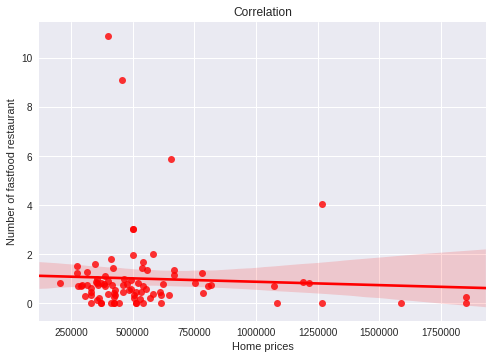

In [33]:
sns.regplot(x='HomePrices', y='FastfoodRestaurant/km2', data=toronto_df_test, color='red')
sns.plt.title('Correlation')
sns.plt.ylabel('Number of fastfood restaurant')
sns.plt.xlabel('Home prices')
sns.plt.show() 

In [34]:
print(toronto_df_test['FastfoodRestaurant/km2'].corr(toronto_df_test['HomePrices']))

-0.053175729088604476


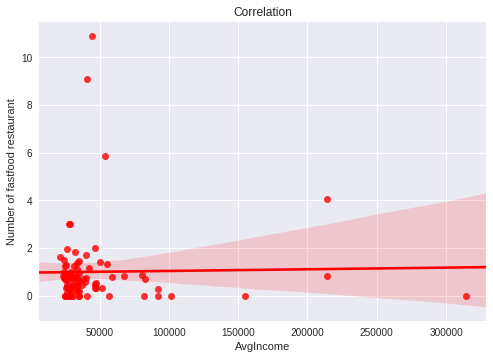

In [35]:
sns.regplot(x='AvgIncome', y='FastfoodRestaurant/km2', data=toronto_df_test, color='red')
sns.plt.title('Correlation')
sns.plt.ylabel('Number of fastfood restaurant')
sns.plt.xlabel('AvgIncome')
sns.plt.show() 

In [36]:
print(toronto_df_test['FastfoodRestaurant/km2'].corr(toronto_df_test['AvgIncome']))

0.018592055631176423


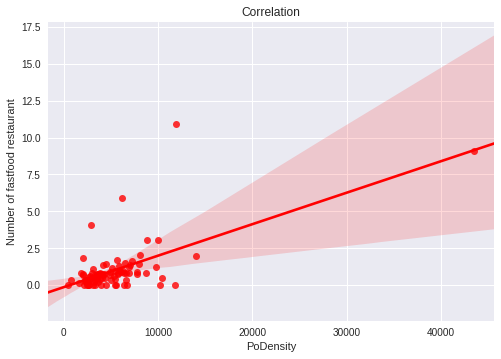

In [37]:
sns.regplot(x='PoDensity', y='FastfoodRestaurant/km2', data=toronto_df_test, color='red')
sns.plt.title('Correlation')
sns.plt.ylabel('Number of fastfood restaurant')
sns.plt.xlabel('PoDensity')
sns.plt.show() 

In [38]:
print(toronto_df_test['FastfoodRestaurant/km2'].corr(toronto_df_test['PoDensity']))

0.6321282925627596


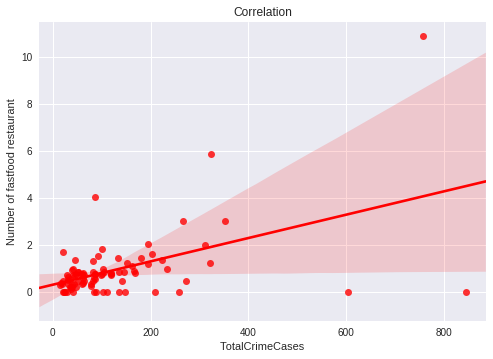

In [50]:
toronto_dfnew = toronto_df_test.drop(5)
sns.regplot(x='TotalCrimeCases/km2', y='FastfoodRestaurant/km2', data=toronto_dfnew, color='red')
sns.plt.title('Correlation')
sns.plt.ylabel('Number of fastfood restaurant')
sns.plt.xlabel('TotalCrimeCases')
sns.plt.show() 

In [52]:
print(toronto_df_test['FastfoodRestaurant/km2'].corr(toronto_df_test['TotalCrimeCases/km2']))

0.5844435642301111


Sadly, from plots above, I see that, the density of fastfood restaurants nearly do not have any correlation with other features except polulation density and total crime cases. My intuition about these features is not accuracy. So, I will use linear regression to find linear relation between number of fastfood restaurant and  polulation density as well as total crime cases

##3. Build the machine learning model

In [0]:
y = toronto_df_test[['FastfoodRestaurant/km2']]
x = toronto_df_test[['PoDensity','TotalCrimeCases/km2']]

In [42]:
x.head()

,PoDensity,TotalCrimeCases/km2
0,3580,30.522088
1,2360,38.259109
2,4934,105.698006
3,2442,102.573529
4,3187,36.247335


Then, I normalize my data set

In [0]:
from sklearn import preprocessing

In [44]:
min_max_scaler = preprocessing.MinMaxScaler()
x = pd.DataFrame(min_max_scaler.fit_transform(x))
x.head()

,0,1
0,0.072783,0.001761
1,0.044459,0.002599
2,0.104218,0.009905
3,0.046363,0.009566
4,0.063659,0.002381


Begin to train in all my data set

In [0]:
from sklearn import linear_model

In [46]:
regr = linear_model.LinearRegression()
regr.fit (x, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [0]:
yhat = regr.predict(x)

In [48]:
compare_neighborhood = pd.DataFrame()
compare_neighborhood['Neighborhood'] = toronto_df_test['Neighborhood']
compare_neighborhood['FastfoodRestaurant/km2'] = y
compare_neighborhood['PredictedFastfoodRestaurant/km2'] = yhat
compare_neighborhood['Difference'] = yhat - y
compare_neighborhood.sort_values('Difference', ascending=False)

,Neighborhood,FastfoodRestaurant/km2,PredictedFastfoodRestaurant/km2,Difference
79,Wallace Emerson,0.000000,2.270363,2.270363
46,Little Portugal,0.000000,1.952719,1.952719
32,High Park North,0.458716,1.901185,1.442469
38,Ionview,0.000000,1.224295,1.224295
10,Branson,0.000000,1.202696,1.202696
28,Forest Hill,0.000000,0.999099,0.999099
13,Casa Loma,0.000000,0.992044,0.992044
61,Old East York,0.377834,1.185985,0.808151
49,Maple Leaf,0.000000,0.801829,0.801829
27,Flemingdon Park,0.823045,1.601832,0.778786


##4. Analyze and Result

The purpose of my machine learning model is to find out which neighborhoods having less fastfood outlets than others. As you can see above, there are some neighborhoods that my model told that, they should be placed more fastfood restaurants. Let's check out five neighborhoods with highest difference

In [61]:
toronto_df.iloc[[30,26,5,14,3],:]

,Neighborhood,Area,PoDensity,AvgIncome,HomePrices,TotalCrimeCases,Latitude,Longitude,Restaurant,Fastfood Restaurant,TotalCrimeCases/km2,Restaurant/km2,Fastfood Restaurant/km2
30,Guildwood,4.77,2688,40806,444309,113,43.754899,-79.197776,4,0,23.6897,0.838574,0.000000
26,Fairbank,4.42,7720,28403,400532,170,43.695689,-79.450310,25,4,38.4615,5.656109,0.904977
5,Bay Street Corridor,0.11,43518,40598,457787,1017,43.665275,-79.387528,10,1,9245.45,90.909091,9.090909
14,Centennial,4.94,2544,34867,423034,204,43.787491,-79.150768,6,0,41.2955,1.214575,0.000000
3,Banbury,2.72,2442,92319,613647,279,43.742796,-79.369957,0,0,102.574,0.000000,0.000000


Bay Street Corridor and Banbury have quite small areas. It's not easy to find a store for rent here and do not have many choices. While Guildwood and Centennial area mainly are public land for park and residents' houses and Centennial. It seems like **Fairbank** is the ideal neighborhood for opening the new KFC restaurant! 

<h3>Fairbank is the most appropriate neighborhood in Toronto to locate your new KFC restaurant!!!</h3>

##5. References
1. https://www.toronto.ca/city-government/data-research-maps/open-data/open-data-catalogue/#e3a085d5-8e94-e279-4c17-33c209141464
2. https://www.toronto.ca/city-government/data-research-maps/open-data/open-data-catalogue/public-safety/
3. https://en.wikipedia.org/wiki/Downtown_Toronto
4. https://en.wikipedia.org/wiki/Demographics_of_Toronto_neighbourhoods